In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import requests
from pathlib import Path
from tqdm.auto import tqdm
import torchvision.transforms as transforms
import os
import random
from PIL import Image
from timeit import default_timer as timer
import zipfile
from typing import Tuple, Dict, List
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
data_path = Path("data/")
image_path = data_path / "spectrogramy"
zip_file_path = data_path / "spektogramy2080.zip"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"{image_path} does not exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

if zip_file_path.is_file():
  with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    print("Unzipping spectrogramy...")
    zip_ref.extractall(image_path)

data/spectrogramy directory already exists
Unzipping spectrogramy...


In [ ]:
#!rm -r data

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} diectories and {len(filenames)} images in '{dirpath}' .")

In [ ]:
walk_through_dir(image_path)

There are 2 diectories and 0 images in 'data/spectrogramy' .
There are 6 diectories and 0 images in 'data/spectrogramy/train' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/D' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/E' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/A' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/B' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/C' .
There are 0 diectories and 64 images in 'data/spectrogramy/train/F' .
There are 6 diectories and 0 images in 'data/spectrogramy/test' .
There are 0 diectories and 16 images in 'data/spectrogramy/test/D' .
There are 0 diectories and 16 images in 'data/spectrogramy/test/E' .
There are 0 diectories and 16 images in 'data/spectrogramy/test/A' .
There are 0 diectories and 16 images in 'data/spectrogramy/test/B' .
There are 0 diectories and 16 images in 'data/spectrogramy/test/C' .
There are 0 diectories and 16 images in '

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
print(f"'{train_dir}' \n'{test_dir}'")

'data/spectrogramy/train' 
'data/spectrogramy/test'


In [ ]:
simple_transform = transforms.Compose([
    transforms.CenterCrop(size=(310, 700)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

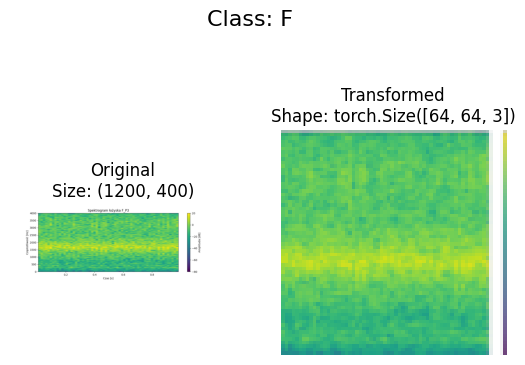

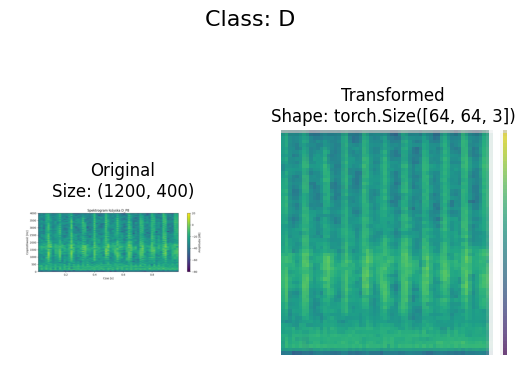

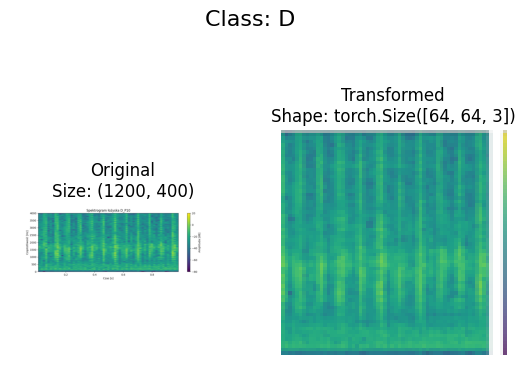

In [ ]:
image_path_list = list(image_path.glob("*/*/*.png"))

def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=simple_transform,
                        n=3,
                        seed=42)

In [ ]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [ ]:
class CustomTinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)                                              # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,                            # Sztuczka do ustalania przez ile mnozyc
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
      #return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operation fusion

In [ ]:
torch.manual_seed(42)
model_0 = CustomTinyVGG(input_shape=3, #number of collor chanels in image data
                  hidden_units=20,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

CustomTinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=6, bias=True)
  )
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[-0.0363,  0.0098, -0.0300,  0.0384, -0.0051, -0.0182],
        [-0.0356,  0.0092, -0.0282,  0.0385, -0.0049, -0.0186],
        [-0.0347,  0.0098, -0.0259,  0.0400, -0.0053, -0.0188],
        [-0.0361,  0.0087, -0.0304,  0.0385, -0.0042, -0.0193],
        [-0.0364,  0.0096, -0.0278,  0.0392, -0.0046, -0.0188],
        [-0.0339,  0.0090, -0.0265,  0.0396, -0.0066, -0.0194],
        [-0.0362,  0.0078, -0.0310,  0.0394, -0.0043, -0.0180],
        [-0.0358,  0.0084, -0.0311,  0.0396, -0.0046, -0.0178],
        [-0.0359,  0.0079, -0.0308,  0.0394, -0.0043, -0.0181],
        [-0.0356,  0.0091, -0.0292,  0.0406, -0.0039, -0.0171],
        [-0.0356,  0.0085, -0.0282,  0.0387, -0.0047, -0.0186],
        [-0.0348,  0.0094, -0.0270,  0.0413, -0.0057, -0.0174],
        [-0.0368,  0.0091, -0.0303,  0.0396, -0.0048, -0.0186],
        [-0.0360,  0.0097, -0.0304,  0.0388, -0.0039, -0.0187],
        [-0.0356,  0.0085, -0.0287,  0.0403, -0.0043, -0.0172],
        [-0.0367,  0.0093, -0.0283,  0.0

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CustomTinyVGG                            [1, 6]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─ReLU: 2-4                         [1, 20, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-7                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 20, 26, 26]           3,620
│    └─ReLU: 2-9                         [1, 20, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 20, 13, 13]           --
├─Seq

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0, 0
  all_preds = []
  all_labels = []


  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

      all_preds.append(test_pred_labels)
      all_labels.append(y)

  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc, all_preds, all_labels

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
          epochs: int=5,
          device=device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  final_preds = []
  final_labels = []
  labels = ['A', 'B', 'C', 'D', 'E', 'F']

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc, epoch_preds, epoch_labels = test_step(model=model,
                                                               dataloader=test_dataloader,
                                                               loss_fn=loss_fn,
                                                               device=device)

    if epoch == epochs - 1:
      final_preds = epoch_preds
      final_labels = epoch_labels

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  final_preds = final_preds.cpu()
  final_labels = final_labels.cpu()

  conf_matrix = confusion_matrix(final_labels, final_preds)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Przewidywane")
  plt.ylabel("Rzeczywiste")
  plt.title("Macierz pomyłek")
  plt.show()

  report = classification_report(final_labels, final_preds, target_names=labels)
  print("Raport klasyfikacji:")
  print(report)

  return results

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.7832 | Train acc: 0.1719 | Test loss: 1.7339 | Test acc: 0.1667
Epoch: 1 | Train loss: 1.6443 | Train acc: 0.2656 | Test loss: 1.4780 | Test acc: 0.3333
Epoch: 2 | Train loss: 1.2867 | Train acc: 0.4818 | Test loss: 1.0451 | Test acc: 0.5000
Epoch: 3 | Train loss: 0.8688 | Train acc: 0.6667 | Test loss: 0.6980 | Test acc: 0.7812
Epoch: 4 | Train loss: 0.5198 | Train acc: 0.8281 | Test loss: 0.3850 | Test acc: 0.8021
Epoch: 5 | Train loss: 0.3519 | Train acc: 0.8464 | Test loss: 0.3331 | Test acc: 0.8333
Epoch: 6 | Train loss: 0.2951 | Train acc: 0.8646 | Test loss: 0.2222 | Test acc: 0.9479
Epoch: 7 | Train loss: 0.1520 | Train acc: 0.9844 | Test loss: 0.1228 | Test acc: 0.9896
Epoch: 8 | Train loss: 0.1068 | Train acc: 0.9870 | Test loss: 0.0814 | Test acc: 1.0000
Epoch: 9 | Train loss: 0.0827 | Train acc: 0.9948 | Test loss: 0.0601 | Test acc: 1.0000
Epoch: 10 | Train loss: 0.0768 | Train acc: 0.9922 | Test loss: 0.0486 | Test acc: 1.0000
Epoch: 11 | Train lo

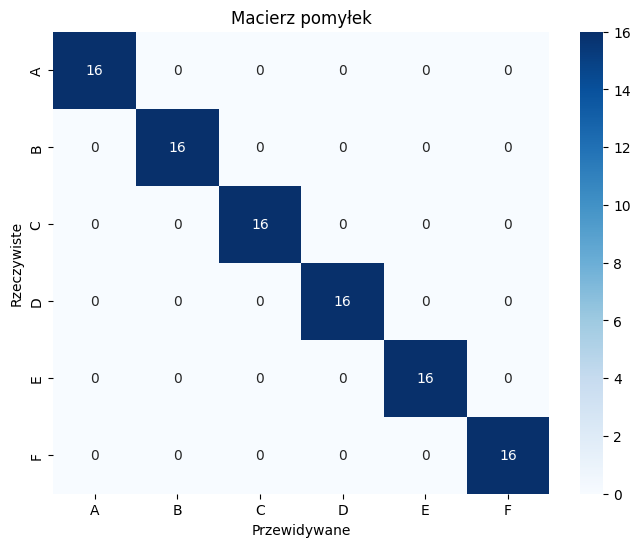

Raport klasyfikacji:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       1.00      1.00      1.00        16
           C       1.00      1.00      1.00        16
           D       1.00      1.00      1.00        16
           E       1.00      1.00      1.00        16
           F       1.00      1.00      1.00        16

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Total training time: 179.741 seconds.


In [ ]:
#torch.manual_seef(42)
#torch.cuda.manual_seed(42)

NUM_EPOCHS = 30
model_0 = CustomTinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  "plots trainnig curves of a results dictionary"

  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

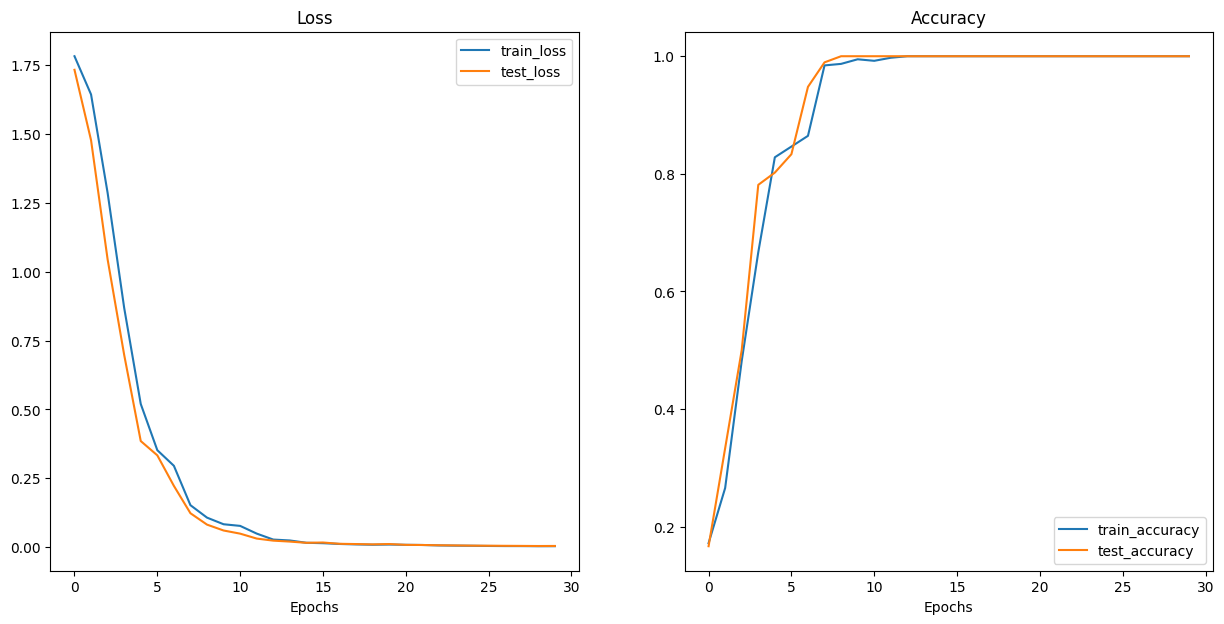

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CNN_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
len(test_data_simple)

96